# Simulation of Complex Systems - Chapter 13
**Author**: Artur Gasparyan

In [204]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

seed = 69420
rng = np.random.default_rng(seed)

## Exercise 13.1

In [2]:
def get_outcomes(T, R, P, S):
    assert T < R < P < S
    
    # Betray = 0
    # Cooperate = 1

    # 0,0 -> P,P
    # 0,1 -> T,S
    # 1,0 -> S,T
    # 1,1 -> R,R
    
    return np.array([
        [[P, P], [T, S]],
        [[S, T], [R, R]]
    ], dtype=np.float32)

In [3]:
def get_years(N, outcomes):
    years_all = np.zeros((N, N, N, 2))

    for n in range(N):
        for m in range(N):
            d1 = np.ones(N, dtype=int)
            d2 = np.ones(N, dtype=int)
            if n < m:
                d1[n:] = 0
                d2[n+1:] = 0
            elif n > m:
                d1[m+1:] = 0
                d2[m:] = 0
            else:
                d1[m:]= 0
                d2[m:]= 0

            outcome = outcomes[d1, d2]
            years_all[n, m, :, :] = outcome
            
    return years_all

In [4]:
N = 10
T = 0
R = 0.5
P = 1
S = 1.5

outcomes = get_outcomes(T, R, P, S)
years_all = get_years(N, outcomes)

In [5]:
def plot_1d(years_all, fig, ax):
    years = years_all[:, 6, :, 0]
    acc_years = np.sum(years, axis=1)
    ax.scatter(np.arange(N), acc_years)
    ax.axvline(6, c='red')
    ax.legend(["outcome", "m"])
    ax.set_ylim(5, 10)
    ax.set_xlabel('n')
    ax.set_ylabel('years')


In [6]:
def plot_2d(years_all, fig, ax):
    years = years_all[:, :, :, 0]
    acc_years = np.sum(years, axis=2)
    im = ax.imshow(acc_years, origin='lower')
    ax.plot(np.arange(1, N), np.arange(N-1), linestyle='--', c='white')
    fig.colorbar(im, ax=ax, label='prison years')
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.legend(["n = m - 1"])

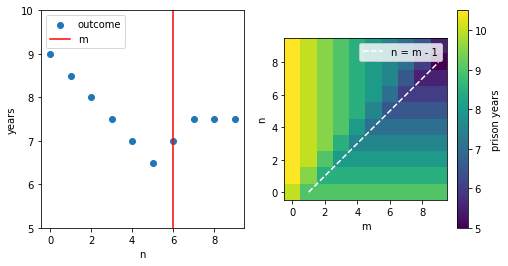

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

plot_1d(years_all, fig=fig, ax=ax1)
plot_2d(years_all, fig=fig, ax=ax2)


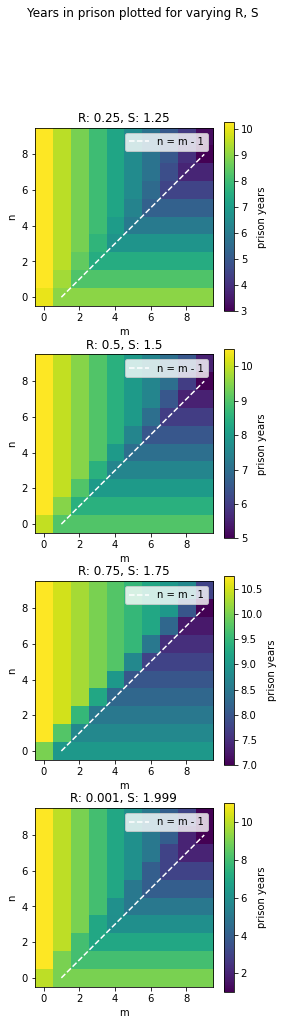

In [8]:
N = 10
T = 0
P = 1

Rs = [0.25, 0.5, 0.75, 0.001]
Ss = [1.25, 1.5, 1.75, 1.999]
n_plots = len(Rs)

fig, axes = plt.subplots(n_plots, 1, figsize=(4, 4*n_plots))
fig.suptitle("Years in prison plotted for varying R, S")

for i in range(n_plots):
    R = Rs[i]
    S = Ss[i]
    ax = axes[i]
    ax.set_title(f'R: {R}, S: {S}')
    
    outcomes = get_outcomes(T, R, P, S)
    years_all = get_years(N, outcomes)
    plot_2d(years_all, fig, ax)
    
    

## Exercise 13.2

In [9]:
def create_strategy(shape, default_value, place_values):
    strats = default_value*np.ones(shape, dtype=int)
    for v, ys, xs in place_values:
        strats[ys, xs] = v

    return strats 

In [10]:
def frame(i):
    ax = plt.gca()
    ax.clear()
    x = np.arange(10)
    y = x.copy()
    y[i%10] = 1
    plot = ax.plot(x, y)
    return plot

In [165]:
from numba import jit, njit, prange

@njit
def play_round(N, T, R, P, S, n, m):
    if n < m:
        return n*R + (N-n-1)*P + T
    elif m < n:
        return m*R + (N-m-1)*P + S
    else:
        return n*R + (N-n)*P


def test_play_round():
    N = 10
    T = 0
    R = 0.5
    P = 1
    S = 1.5
    
    n = 5
    m = 6
    
    outcomes = play_round(N, T, R, P, S, n, m)
    expected_outcome = [
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.5, 0.5],
        [0.,  1.5],
        [1.,  1. ],
        [1.,  1. ],
        [1.,  1. ],
        [1.,  1. ]
    ]
    
    assert np.all(np.isclose(outcomes, expected_outcome))    
    
#test_play_round()

In [175]:
from numba import prange
import math

@njit
def play_competition(N, T, R, P, S, strats):
    L = strats.shape[0]
    scores = np.zeros((L, L))
    offsets = np.array(((1, 0), (0, 1), (-1, 0), (0, -1)))


    for i in prange(L*L):
        y = i//L
        x = i%L
        score = 0

        for (dy, dx) in offsets:
            n = strats[y, x]
            m = strats[(y+dy)%L, (x+dx)%L]

            n_years = play_round(N, T, R, P, S, n, m)
            score += play_round(N, T, R, P, S, n, m)

        scores[y, x] = score
        
    return scores

In [176]:
def revise_strats(strats, scores):
    old_strats = strats.copy()
    offsets = np.array(((1, 0), (0, 1), (-1, 0), (0, -1)))
    
    for y in range(L):
        for x in range(L):
            min_score = scores[y, x]
            min_pos = [(y, x)]

            for (dy, dx) in offsets:
                p = ny, nx = (y+dy)%L, (x+dx)%L
                score = scores[ny, nx]

                if score < min_score:
                    min_score = score
                    min_pos = [p]

                elif score == min_score:
                    min_pos.append(p)

            p_choice = rng.choice(min_pos)
            strats[y, x] = old_strats[p_choice[0], p_choice[1]]
            

                    
    ...

In [182]:
def mutate_strats(strats, N, mu, always_binary=True):
    
    if always_binary:
        choices = np.array([0, N], dtype=strats.dtype) 
    else:
        choices = np.arange(N+1).astype(strats.dtype)
    
        
    mutation_indexes = rng.random(size=strats.shape) < mu
    mutation_values = rng.choice(choices, size=mutation_indexes.sum())

    strats[mutation_indexes] = mutation_values

In [194]:
def run_sim(n_timesteps, strats_start, N, L, T, P, S, R, mu, binary=True):
    strats = strats_start.copy()
    
    history = [strats.copy()]
    for i in range(1, n_timesteps):
        scores = play_competition(N, T, R, P, S, strats)
        revise_strats(strats, scores)
        mutate_strats(strats, N, mu, binary)
        history.append(strats.copy())
        
    return history

### Analysing single defector

<IPython.core.display.Javascript object>


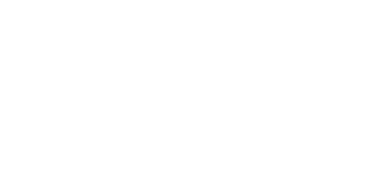

In [195]:
%matplotlib notebook


def draw_frame(i_frame, ax, history):
    strat = history[i_frame]
    ax.clear()
    ax.imshow(strat)
    ax.set_title(f"t={i_frame}")
    

N = 7
L = 30
T = 0
P = 1
R = 0.9
S = 1.5
mu = 0
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)
history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu, binary=True)

fig = plt.figure()
ax = fig.gca()
animation = anim.FuncAnimation(fig, draw_frame, frames=len(history), fargs=(ax, history), repeat=True)
fig.show()

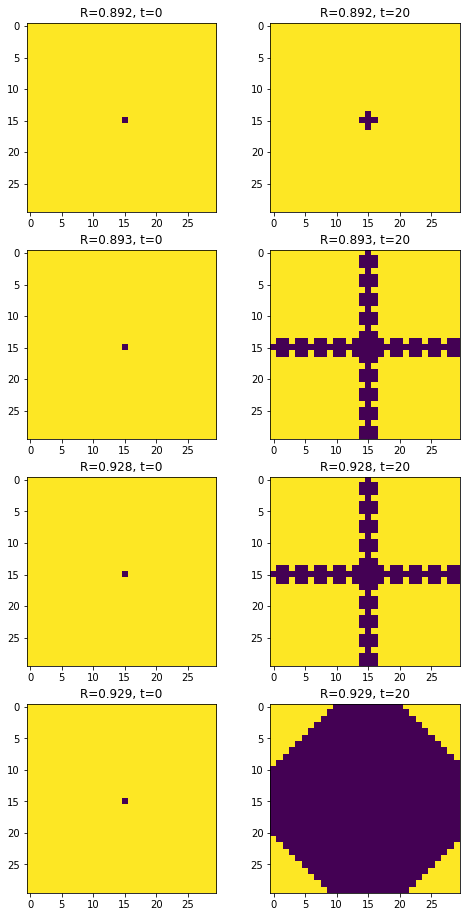

In [196]:
%matplotlib inline

N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Rs = [0.892, 0.893, 0.928, 0.929]       # min: 0.892, max: 0.928
fig, axes = plt.subplots(4, 2, figsize=(8, 16))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"R={R}, t=0")
    ax2.set_title(f"R={R}, t={n_timesteps-1}")

### Analysing multiple defectors

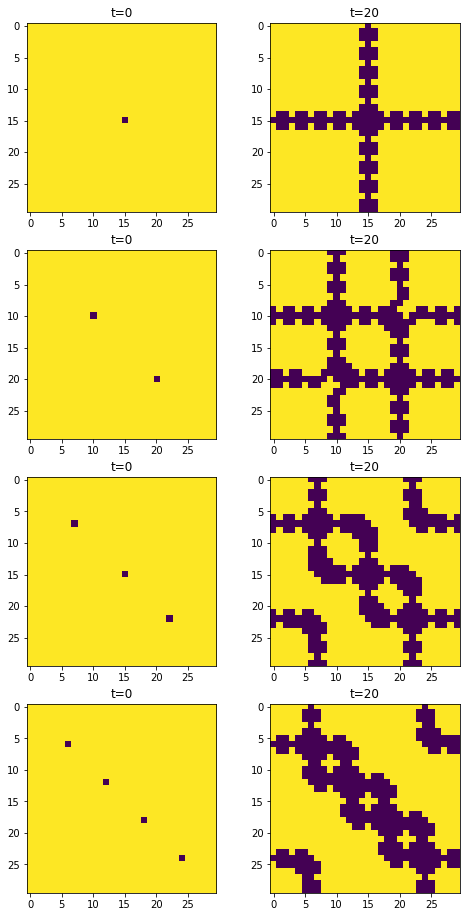

In [197]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
R = 0.9
mu = 0
n_timesteps = 21
stratss = [
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//2], [L//2])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//3, 2*L//3], [L//3, 2*L//3])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//4, 2*L//4, 3*L//4], [L//4, 2*L//4, 3*L//4])]
    ),
    create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//5, 2*L//5, 3*L//5, 4*L//5], [L//5, 2*L//5, 3*L//5, 4*L//5])]
    ),   
]

fig, axes = plt.subplots(4, 2, figsize=(8, 16))
for i, strats in enumerate(stratss):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax1.set_title("t=0")
    ax2.imshow(history[-1])
    ax2.set_title(f"t={n_timesteps-1}")

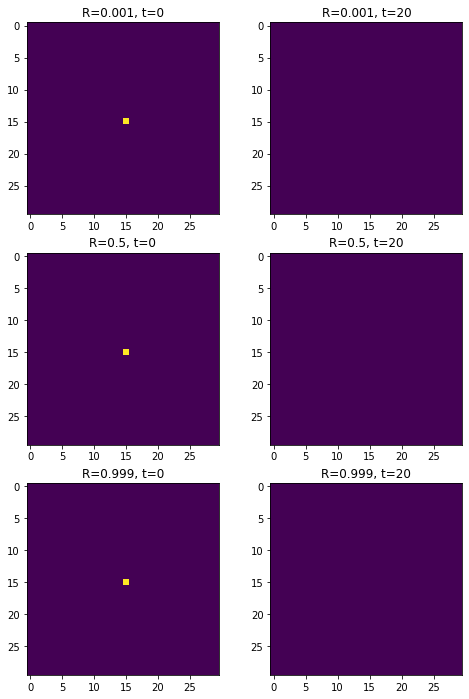

In [198]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0
n_timesteps = 21
strats = create_strategy(
    shape=(L, L),
    default_value=0,
    place_values = [(N, [L//2], [L//2])]
)

Rs = [0.001, 0.5, 0.999]

fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax1.set_title(f"R={R}, t=0")
    ax2.imshow(history[-1])
    ax2.set_title(f"R={R}, t={n_timesteps-1}")

## Exercise 13.3

### Analysing R

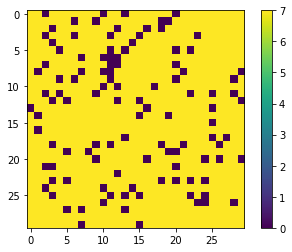

In [199]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
R = 0.825
mu = 0.01

n_timesteps = 700
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)

fig = plt.figure()
im = plt.imshow(history[-1])
plt.colorbar(im)

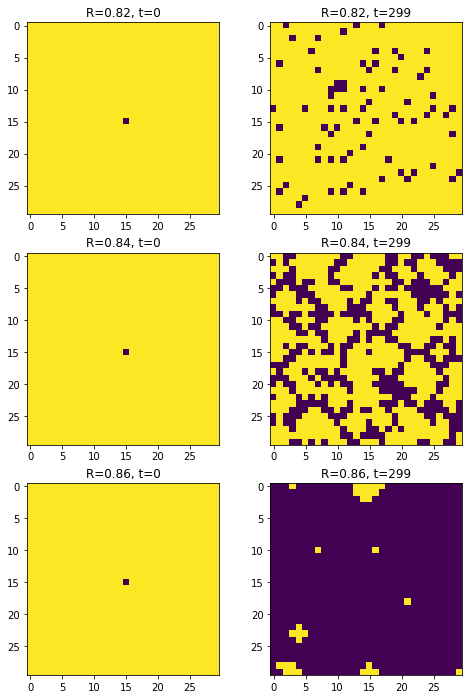

In [116]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0.01

n_timesteps = 300
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Rs = [0.82, 0.84, 0.86]
fig, axes = plt.subplots(3, 2, figsize=(8, 12))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"R={R}, t=0")
    ax2.set_title(f"R={R}, t={n_timesteps-1}")

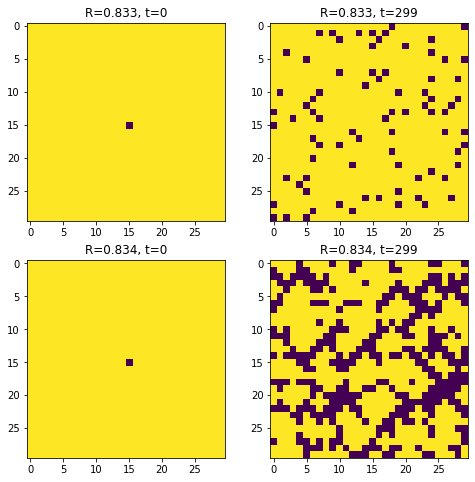

In [117]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0.01

n_timesteps = 300
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Rs = [0.833, 0.834]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"R={R}, t=0")
    ax2.set_title(f"R={R}, t={n_timesteps-1}")

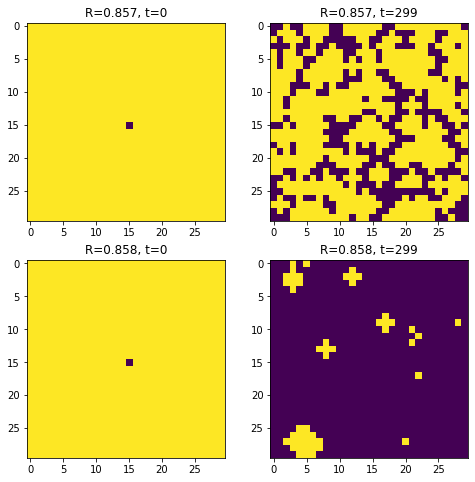

In [118]:
N = 7
L = 30
T = 0
P = 1
S = 1.5
mu = 0.01

n_timesteps = 300
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Rs = [0.857, 0.858]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, R in enumerate(Rs):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"R={R}, t=0")
    ax2.set_title(f"R={R}, t={n_timesteps-1}")

### Analysing S

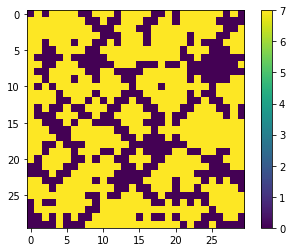

In [130]:
N = 7
L = 30
T = 0
P = 1
S = 1.35
R = 0.84
mu = 0.01

n_timesteps = 300
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)

fig = plt.figure()
im = plt.imshow(history[-1])
plt.colorbar(im)

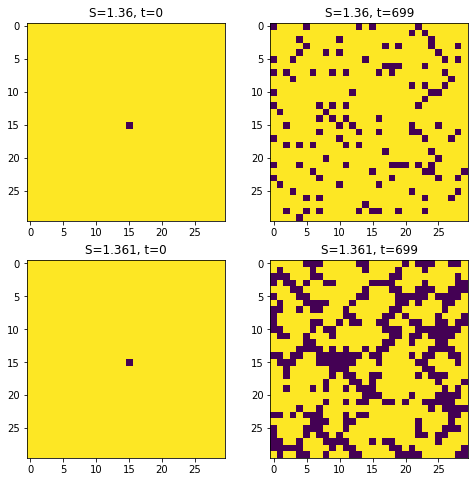

In [138]:
N = 7
L = 30
T = 0
P = 1
R = 0.84
mu = 0.01

n_timesteps = 700
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Ss = [1.360, 1.361]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, S in enumerate(Ss):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"S={S}, t=0")
    ax2.set_title(f"S={S}, t={n_timesteps-1}")

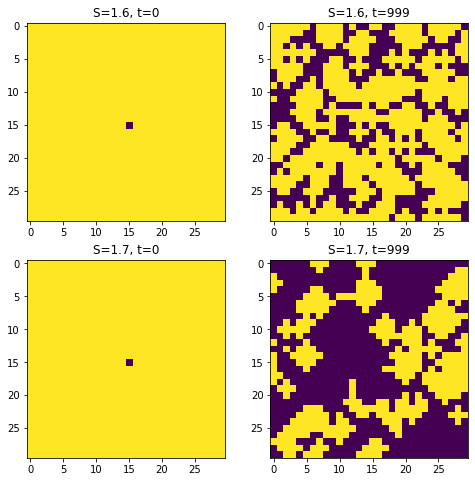

In [203]:
%matplotlib inline

N = 7
L = 30
T = 0
P = 1
R = 0.84
mu = 0.01

n_timesteps = 1000
strats = create_strategy(
    shape=(L, L),
    default_value=N,
    place_values = [(0, [L//2], [L//2])]
)

Ss = [1.6, 1.7]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, S in enumerate(Ss):
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu)
    ax1, ax2 = axes[i]
    ax1.imshow(history[0])
    ax2.imshow(history[-1])
    ax1.set_title(f"S={S}, t=0")
    ax2.set_title(f"S={S}, t={n_timesteps-1}")

## Exercise 13.4

In [242]:
def explore_distribution(R):
    N = 7
    L = 30
    T = 0
    P = 1
    S = 1.5
    mu = 0.01
    n_timesteps = 300
    strats = create_strategy(
        shape=(L, L),
        default_value=N,
        place_values = [(0, [L//2], [L//2])]
    )
    history = run_sim(n_timesteps, strats, N, L, T, P, S, R, mu, binary=False)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"R={R}")
    
    axes[0].imshow(history[99])
    axes[0].set_title("t=99")

    axes[1].imshow(history[199])
    axes[1].set_title("t=199")

    axes[2].imshow(history[299])
    axes[2].set_title("t=299")


    evolution = np.array(history)
    pop_dist = np.zeros((N, n_timesteps))

    for t in range(n_timesteps):
        for i in range(N):
            strats = history[t]
            pop_dist[i, t] = np.sum(strats==i)

    pop_dist /= (L*L)

    fig = plt.figure()
    ax = fig.gca()
    for i in range(N):
        ax.plot(np.arange(n_timesteps), pop_dist[i, np.arange(n_timesteps)])

    ax.legend([f"n={i}" for i in range(N)])

    ...;

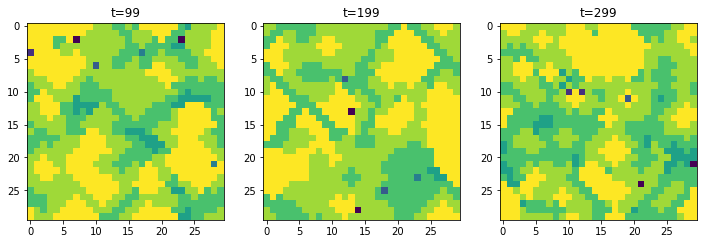

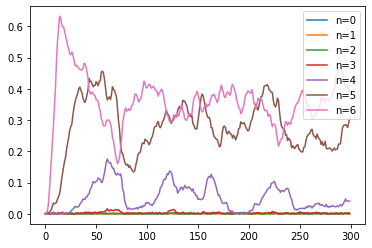

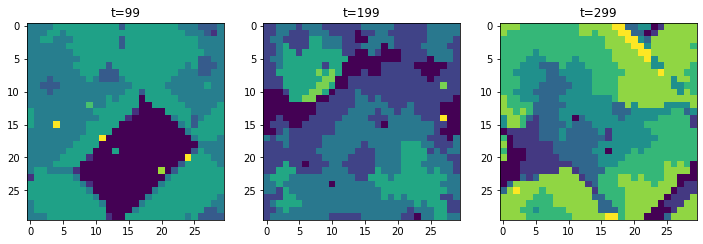

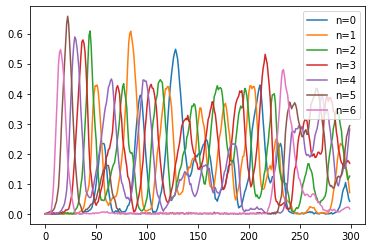

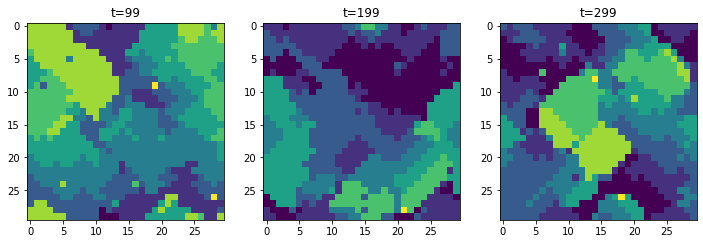

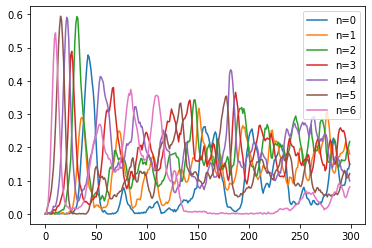

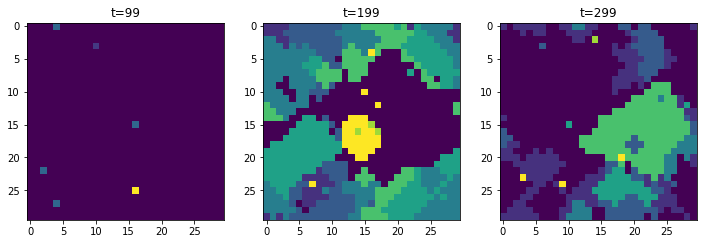

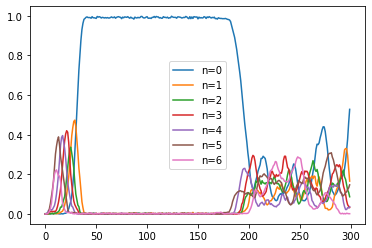

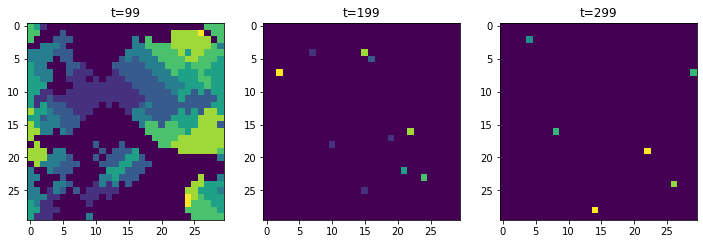

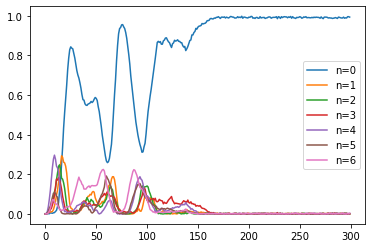

In [254]:
for R in [0.4, 0.5, 0.6, 0.7, 0.8]:
    explore_distribution(R)

Conclusion: Systems tend toward cooperation if the expected reward is greater than that of exploitation